In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Motivation

这是我们的问题。 我们有要跟踪的移动物体。 也许这些物体是战斗机和导弹，或者我们正在跟踪在田野里打板球的人。 这并不重要。 我们学到的哪些过滤器可以处理这个问题？ 不幸的是，它们都不是理想的。 我们来思考一下这个问题的特点。

* **multimodal**：我们希望同时跟踪零个、一个或多个对象。

* **遮挡**：一个对象可以隐藏另一个对象，从而对多个对象进行一次测量。

* **非线性行为**：飞机受到风的冲击，球沿抛物线运动，人们相互碰撞。

* **非线性测量**：雷达为我们提供到物体的距离。 将其转换为 (x,y,z) 坐标需要平方根，这是非线性的。

* **非高斯噪声：** 当物体在背景上移动时，计算机视觉可能会将部分背景误认为是物体。

* **连续：** 对象的位置和速度（即状态空间）可以随时间平滑变化。

* **multivariate**：我们想要跟踪多个属性，例如位置、速度、转弯率等。

* **未知进程模型**：我们可能不知道系统的进程模型


我们学到的过滤器都不能很好地处理所有这些约束。

* **离散贝叶斯过滤器**：它具有大部分属性。 它是多模态的，可以处理非线性测量，并且可以扩展到处理非线性行为。 然而，它是离散的和单变量的。

* **卡尔曼滤波器**：卡尔曼滤波器为具有高斯噪声的单峰线性系统产生最佳估计。 对于我们的问题，这些都不是真的。

* **无迹卡尔曼滤波器**：UKF 处理非线性、连续、多变量问题。 然而，它不是多模态的，也不处理遮挡。 它可以处理适度非高斯的噪声，但不能很好地处理非常非高斯的分布或非常非线性的问题。

* **扩展卡尔曼滤波器**：EKF 具有与 UKF 相同的优点和局限性，不同之处在于它对强非线性和非高斯噪声更加敏感。

## Monte Carlo Sampling

在 UKF 章节中，我生成了一个与此类似的图来说明非线性系统对高斯的影响：

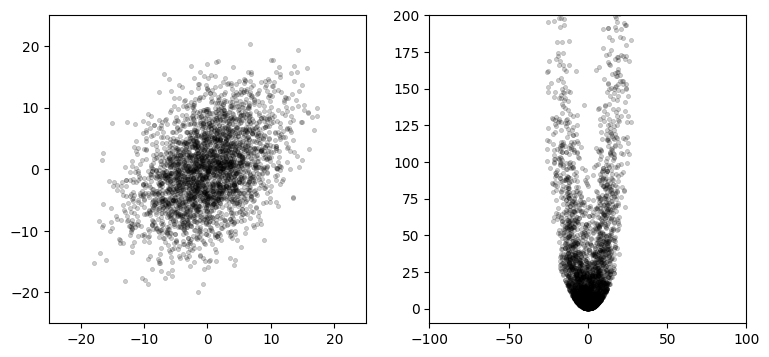

In [3]:
import kf_book.pf_internal as pf_internal
pf_internal.plot_monte_carlo_ukf()

左图显示了基于高斯分布的 3,000 个正态分布点

$$\mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix}$$

右图显示了通过这组方程的这些点：

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

使用有限数量的随机采样点来计算结果称为 [*Monte Carlo*](https://en.wikipedia.org/wiki/Monte_Carlo_method) (MC) 方法。 这个想法很简单。 生成足够多的点以获得问题的代表性样本，通过您正在建模的系统运行这些点，然后计算转换点的结果。

简而言之，这就是粒子过滤的作用。 我们在整本书中一直使用的贝叶斯过滤器算法应用于数千个粒子，其中每个粒子代表系统的一个*可能*状态。 我们使用粒子的加权统计从数千个粒子中提取估计状态。

## Generic Particle Filter Algorithm

1. **随机生成一堆粒子**
    
  粒子可以具有位置、航向和/或您需要估计的任何其他状态变量。每个都有一个权重（概率），表明它与系统的实际状态相匹配的可能性。用相同的权重初始化每个。
  
2. **预测粒子的下一个状态**

 根据您预测真实系统行为的方式移动粒子。

3. **更新**

  根据测量值更新粒子的权重。与测量值密切匹配的粒子的权重高于与测量值不太匹配的粒子。
  
4. **重新采样**

  丢弃极不可能的粒子并用更可能的粒子的副本替换它们。
  
5. **计算估计值**

  或者，计算一组粒子的加权均值和协方差以获得状态估计。

这种朴素的算法具有我们需要克服的实际困难，但这是总体思路。让我们看一个例子。我为 UKF 和 EKF 章节中的机器人定位问题编写了一个粒子过滤器。机器人具有转向和速度控制输入。它有传感器，可以测量到可见地标的距离。传感器和控制机构都有噪音，我们需要跟踪机器人的位置。

在这里，我运行了一个粒子过滤器并绘制了粒子的位置。左边的图是经过 1 次迭代后的，右边是经过 10 次迭代后的。红色“X”表示机器人的实际位置，大圆圈是计算出的加权平均位置。

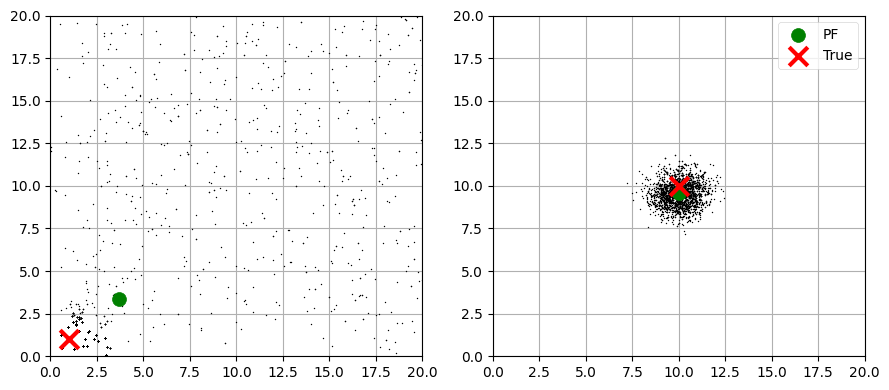

In [4]:
pf_internal.show_two_pf_plots()

如果您在浏览器中查看此动画，则会显示整个序列：

<img src='animations/particle_filter_anim.gif'>

在第一次迭代后，粒子仍然主要随机散布在地图周围，但您可以看到有些粒子已经聚集在机器人位置附近。计算出的平均值非常接近机器人的位置。这是因为每个粒子都根据它与测量值的匹配程度进行加权。机器人靠近 (1,1)，因此靠近 (1, 1) 的粒子将具有很高的权重，因为它们与测量值非常匹配。远离机器人的粒子将与测量值不匹配，因此重量非常低。估计位置计算为粒子位置的加权平均值。机器人附近的粒子对计算的贡献更大，因此估计非常准确。

几次迭代后，您可以看到所有粒子都聚集在机器人周围。这是由于*重采样*步骤。重采样会丢弃非常不可能（非常低的权重）的粒子，并用概率更高的粒子替换它们。

我还没有完全展示*为什么*这是有效的，也没有完全解释粒子加权和重采样的算法，但它应该具有直观的意义。制作一堆随机粒子，移动它们，使它们“有点”跟随机器人，根据它们与测量值的匹配程度对它们进行加权，只让可能的粒子存活。看起来它应该有效，而且确实如此。

## Probability distributions via Monte Carlo

假设我们想知道曲线 $y= \mathrm{e}^{\sin(x)}$ 在区间 [0, $\pi$] 下的面积。面积用定积分 $\int_0^\pi \mathrm{e}^{\sin(x)}\, \mathrm{d}x$ 计算。作为练习，继续寻找答案；我会等待。

如果你很聪明，你就没有接受那个挑战； $\mathrm{e}^{\sin(x)}$ 无法解析积分。世界充满了我们无法整合的方程式。例如，考虑计算一个物体的光度。一个物体反射了一些撞击它的光。一些反射光从其他物体反射回来并重新撞击原始物体，增加了亮度。这将创建一个*递归积分*。祝一切顺利。

然而，使用蒙特卡罗技术计算积分是微不足道的。要查找曲线下的面积，请创建一个包含所需间隔中的曲线的边界框。在框中生成随机定位的点，并计算落在曲线下的点与点总数的比率。例如，如果 40% 的点在曲线下方且边界框的面积为 1，则曲线下方的面积约为 0.4。当您趋向于无限点时，您可以实现任意精度。在实践中，几千点会给你一个相当准确的结果。

您可以使用此技术对任意难度的函数进行数值积分。这包括不可积和不连续的函数。这项技术是由洛斯阿拉莫斯国家实验室的斯坦利乌拉姆发明的，使他能够对纸上无法解决的核反应进行计算。

让我们通过找到圆的面积来计算 $\pi$。 我们将定义一个半径为 1 的圆，并将其绑定在一个正方形中。 正方形的边长为2，所以面积为4。我们在盒子内生成一组均匀分布的随机点，并计算有多少落在圆内。 圆的面积计算为框的面积乘以圆内点与点总数的比率。 最后，我们知道 $A = \pi r^2$，所以我们计算 $\pi = A / r^2$。

我们从创建点开始。

```python
N = 20000
pts = uniform(-1, 1, (N, 2))
```

如果点到圆心的距离小于或等于半径，则该点在圆内。 我们用 `numpy.linalg.norm` 计算距离，它计算向量的大小。 由于向量从 (0, 0) 开始，调用 norm 将计算点与原点的距离。

```python
dist = np.linalg.norm(pts, axis=1)
```

接下来我们计算哪些距离符合标准。 如果满足条件“dist <= 1”，此代码将返回一个包含“True”的 bool 数组：

```python
in_circle = dist <= 1
```

剩下的就是计算圆内的点数，计算 pi 并绘制结果。 我已将其全部放在一个单元格中，因此您可以尝试使用“N”（点数）的替代值。

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


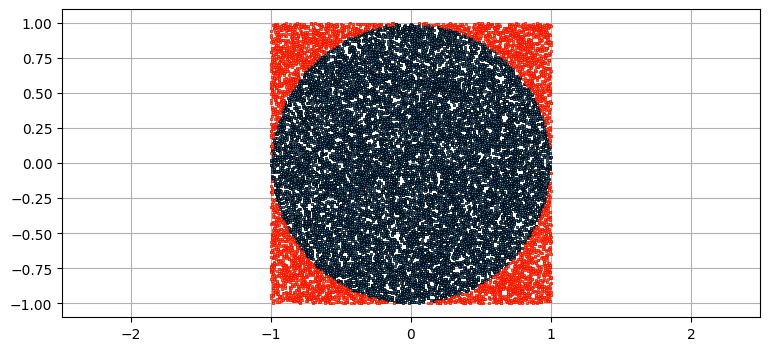

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 

N = 20000  # number of points
radius = 1.
area = (2*radius)**2

pts = uniform(-1, 1, (N, 2))

# distance from (0,0) 
dist = np.linalg.norm(pts, axis=1)
in_circle = dist <= 1

pts_in_circle = np.count_nonzero(in_circle)
pi = 4 * (pts_in_circle / N)

# plot results
plt.scatter(pts[in_circle,0], pts[in_circle,1], 
            marker=',', edgecolor='k', s=1)
plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
            marker=',', edgecolor='r', s=1)
plt.axis('equal')

print(f'mean pi(N={N})= {pi:.4f}')
print(f'err  pi(N={N})= {np.pi-pi:.4f}')

这一见解使我们意识到我们可以使用蒙特卡罗来计算任何概率分布的概率密度。 例如，假设我们有这个高斯分布：

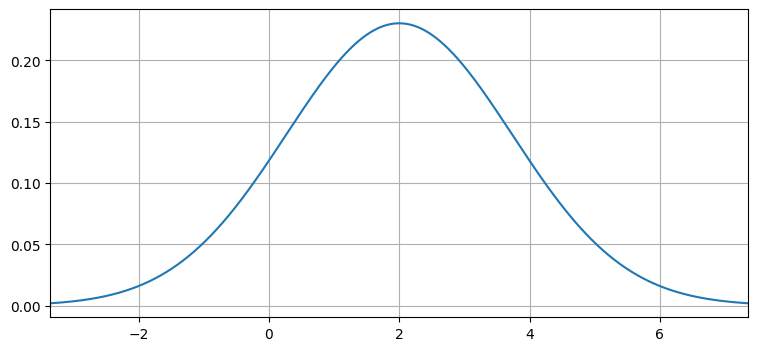

In [6]:
from filterpy.stats import plot_gaussian_pdf
plot_gaussian_pdf(mean=2, variance=3);

概率密度函数 (PDF) 给出随机值落在 2 个值之间的概率。 例如，我们可能想知道上图中 x 在 0 和 2 之间的概率。 这是一个连续函数，因此我们需要通过积分来找到曲线下的面积，因为面积等于该值范围发生的概率。

$$P[a \le X \le b] = \int_a^b f_X(x) \, dx$$

计算高斯积分很容易。 但现实生活并没有那么容易。 例如，下图显示了概率分布。 没有办法对任意曲线进行分析描述，更不用说对其进行积分了。

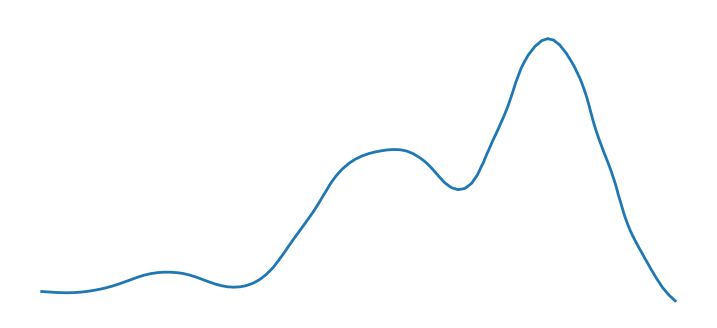

In [7]:
pf_internal.plot_random_pd()

我们可以使用蒙特卡罗方法来计算任何积分。 PDF 是用积分计算的，因此我们可以使用 Monte Carlo 计算这条曲线的 PDF。

## The Particle Filter

所有这些都将我们带到了粒子过滤器。考虑在城市环境中跟踪机器人或汽车。为了保持一致性，我将使用 EKF 和 UKF 章节中的机器人定位问题。在这个问题中，我们跟踪了一个具有传感器的机器人，该传感器测量已知地标的范围和方位。

粒子过滤器是一系列算法。我正在展示一种特定形式的粒子滤波器，它可以直观地掌握并与我们在本书中研究的问题相关。这将使一些步骤看起来有点“神奇”，因为我没有提供完整的解释。这将在本章后面进行。

根据上一节的讨论，我们首先创建数千个*粒子*。每个粒子都有一个位置，表示机器人在场景中的位置的可能信念，可能还有航向和速度。假设我们不知道机器人的位置。我们希望将粒子均匀地散布在整个场景中。如果考虑所有代表概率分布的粒子，粒子越多的位置表示置信度越高，粒子越少的位置表示置信度越低。如果在特定位置附近有一大块粒子，这意味着我们更确定机器人在那里。

每个粒子都需要一个权重——理想情况下是它代表机器人真实位置的概率。这个概率很少是可计算的，所以我们只要求它与可计算的概率成比例*。在初始化时，我们没有理由偏爱一个粒子而不是另一个粒子，因此我们为 $N$ 粒子分配了 $1/N$ 的权重。我们使用 $1/N$ 使所有概率的总和等于 1。

粒子和权重的组合形成了我们问题的*概率分布*。回想一下*离散贝叶斯* 一章。在那一章中，我们将走廊中的位置建模为离散且均匀间隔的位置。这非常相似，除了粒子随机分布在连续空间中，而不是限制在离散位置。在这个问题中，机器人可以在任意维度的平面上移动，右下角位于 (0,0)。

为了跟踪我们的机器人，我们需要维护 x、y 和航向的状态。我们将“N”个粒子存储在一个“(N, 3)”形状的数组中。三列依次包含 x、y 和标题。

如果您被动地跟踪某物（没有控制输入），那么您需要在状态中包含速度并使用该估计值进行预测。更多的维度需要指数级更多的粒子来形成一个好的估计，所以我们总是尽量减少状态中随机变量的数量。

这段代码在一个区域上创建了一个均匀的高斯分布的粒子：

In [8]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

例如：

In [9]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.772, 0.336, 4.171],
       [0.333, 0.34 , 4.319],
       [0.6  , 0.274, 5.02 ],
       [0.054, 0.022, 5.034]])

### Predict Step


贝叶斯算法中的预测步骤使用过程模型来更新对系统状态的置信度。 我们将如何用粒子来做到这一点？ 每个粒子代表机器人的一个可能位置。 假设我们向机器人发送一个命令，让机器人移动 0.1 米，同时转动 0.007 弧度。 我们可以按这个量移动每个粒子。 如果我们这样做，我们很快就会遇到问题。 机器人的控制并不完美，因此它不会完全按照指令移动。 因此，我们需要为粒子的运动添加噪声，以便有合理的机会捕捉到机器人的实际运动。 如果您不对系统中的不确定性建模，粒子滤波器将无法正确建模我们对机器人位置的信念的概率分布。

In [10]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

### Update Step

接下来我们会得到一组测量值——针对当前视图中的每个地标。 应该如何使用这些测量来改变我们由粒子建模的概率分布？

回想一下**离散贝叶斯**章节。 在那一章中，我们将走廊中的位置建模为离散且均匀间隔的位置。 我们为每个位置分配了一个概率，我们称之为 *prior*。 当新的测量值出现时，我们将该位置的当前概率（*先验*）乘以测量值与该位置匹配的*可能性*：

```python
def update(likelihood, prior):
    posterior = prior * likelihood
    return normalize(posterior)
```

这是等式的一个实现

$$x = \| \mathcal L \bar x \|$$

这是贝叶斯定理的实现：

$$\begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}\end{aligned}$$

我们对我们的粒子做同样的事情。 每个粒子都有一个位置和一个权重，用于估计它与测量的匹配程度。 将权重归一化，使它们的总和为 1，从而将它们转化为概率分布。 离机器人最近的粒子通常比远离机器人的粒子具有更高的权重。

In [11]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

在文献中，这部分算法称为*顺序重要性采样*，或 SIS。 权重方程称为*重要性密度*。 我将在下一节中给出这些理论基础。 现在我希望这具有直观的意义。 如果我们根据粒子与测量值的匹配程度对粒子进行加权，则在合并测量值后，它们可能是系统概率分布的良好样本。 理论证明确实如此。 权重是贝叶斯定理中的*似然*。 不同的问题需要以略有不同的方式来解决这一步，但这是总体思路。

### Computing the State Estimate

在大多数应用程序中，您会想知道每次更新后的估计状态，但过滤器仅由一组粒子组成。 假设我们正在跟踪一个对象（即它是单峰的），我们可以将估计的平均值计算为粒子加权值的总和。

$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$

这里我采用符号 $x^i$ 来表示 $\mathtt{i}^{th}$ 粒子。 使用上标是因为我们经常需要使用下标来表示 $\mathtt{k}^{th}$ 或 $\mathtt{k+1}^{th}$ 粒子的时间步长，产生笨重的 $x^i_ {k+1}$。

此函数计算粒子的均值和方差：

In [12]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

如果我们在一个 1x1 的正方形中创建一个均匀分布的具有相等权重的点，我们会在 (0.5, 0.5) 处获得一个非常靠近正方形中心的平均位置和一个小的方差。

In [13]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.494, 0.514]), array([0.083, 0.085]))

### Particle Resampling

SIS 算法存在*退化问题*。 它从具有相等权重的均匀分布的粒子开始。 机器人附近可能只有少数粒子。 当算法运行时，任何与测量值不匹配的粒子都将获得极低的权重。 只有靠近机器人的粒子才会有可观的重量。 我们可以有 5,000 个粒子，其中只有 3 个对状态估计做出有意义的贡献！ 我们说过滤器已经*退化*。这个问题通常通过某种形式的*重采样*粒子来解决。

权重很小的粒子并不能有意义地描述机器人的概率分布。 重采样算法丢弃概率非常低的粒子，并用概率更高的新粒子替换它们。 它通过以相对较高的概率复制粒子来做到这一点。 重复项因在预测步骤中添加的噪声而略微分散。 这会产生一组点，其中大部分粒子准确地表示概率分布。

有许多重采样算法。 现在让我们看看最简单的一种*简单随机重采样*，也称为*多项式重采样*。 它从当前粒子集采样 $N$ 次，从样本中生成一组新的粒子。 选择任何给定粒子的概率应该与其权重成正比。

我们使用 NumPy 的 `cumsum` 函数来实现这一点。 `cumsum` 计算数组的累积和。 即元素一是元素零和一之和，元素二是元素零、一、二等的总和。 然后我们生成0.0到1.0范围内的随机数，并进行二分查找以找到权重 最接近该数字的那个：

In [14]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

我们不会在每个时期重新采样。 例如，如果您没有收到新的测量结果，您就没有收到任何可以使重采样受益的信息。 我们可以通过使用称为*有效 N* 的东西来确定何时重新采样，它近似地测量对概率分布有意义的粒子数量。 这个方程是

$$\hat{N}_\text{eff} = \frac{1}{\sum w^2}$$

我们可以在 Python 中实现它

In [15]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

如果 $\hat{N}_\text{eff}$ 低于某个阈值，则是重新采样的时候了。 一个有用的起点是 $N/2$，但这因问题而异。 $\hat{N}_\text{eff} = N$ 也是可能的，这意味着粒子集已经折叠到一个点（每个点的权重相同）。 它在理论上可能不是纯粹的，但如果发生这种情况，我会创建一个新的粒子分布，希望能生成更多样的粒子。 如果您经常遇到这种情况，您可能需要增加粒子数量，或者调整过滤器。 稍后我们将更多地讨论这一点。

## SIR Filter  - A Complete Example

还有更多东西要学，但我们知道的足以实现一个完整的粒子过滤器。 我们将实现*采样重要性重采样过滤器*，或 SIR。

我需要介绍一种比上面给出的更复杂的重采样方法。 FilterPy 提供了几种重采样方法。 我稍后会描述它们。 它们采用一组权重并将索引返回到已选择进行重采样的粒子。 我们只需要编写一个函数来从这些索引中执行重采样：

In [16]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

为了实现过滤器，我们需要创建粒子和地标。 然后我们执行一个循环，依次调用预测、更新、重采样，然后用估计计算新的状态估计。

final position error, variance:
	 [-0.106  0.106] [0.009 0.008]


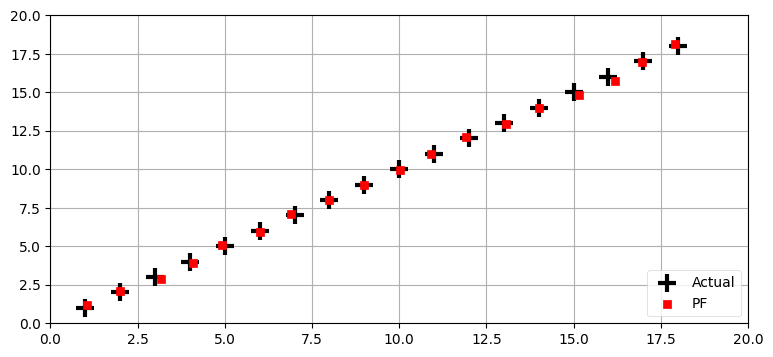

In [17]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

大部分代码用于初始化和绘图。 整个粒子过滤处理由以下几行组成：

```python
# move diagonally forward to (x+1, x+1)
predict(particles, u=(0.00, 1.414), std=(.2, .05))

 # incorporate measurements
update(particles, weights, z=zs, R=sensor_std_err, 
       landmarks=landmarks)
       
# resample if too few effective particles
if neff(weights) < N/2:
    indexes = systematic_resample(weights)
    resample_from_index(particles, weights, indexes)

mu, var = estimate(particles, weights)
```

第一行假设机器人沿直线移动 (`u[0] == 0`) 并在 x 轴和 y 轴上移动 1 个单位 (`u[1]= =1.414`）。转弯误差的标准差为 0.2，距离的标准差为 0.05。当此调用返回时，粒子将全部向前移动，但权重不再正确，因为它们尚未更新。

下一行将测量值合并到过滤器中。这不会改变粒子的位置，它只会改变权重。如果你回想一下，粒子的权重被计算为它与传感器误差模型的高斯匹配的概率。粒子离测量距离越远，它就越不可能是一个好的表示。

最后两行示例有效粒子数 ($\hat{N}_\text{eff})$。如果它低于 $N/2$，我们将执行重采样以确保我们的粒子形成实际概率分布的良好表示。

现在让我们看看所有绘制的粒子。以交互方式看到这种情况的发生更有启发性，但这种格式仍然为我们提供了有用的信息。我在非常淡的绿色和大圆圈中绘制了点的原始随机分布，以帮助将它们与随后的迭代区分开来，其中粒子用黑色像素绘制。粒子的数量让我们很难看到细节，所以我将迭代次数限制为 8 次，以便我们可以放大并更仔细地观察。

final position error, variance:
	 [-0.019 -0.005] [0.005 0.006]


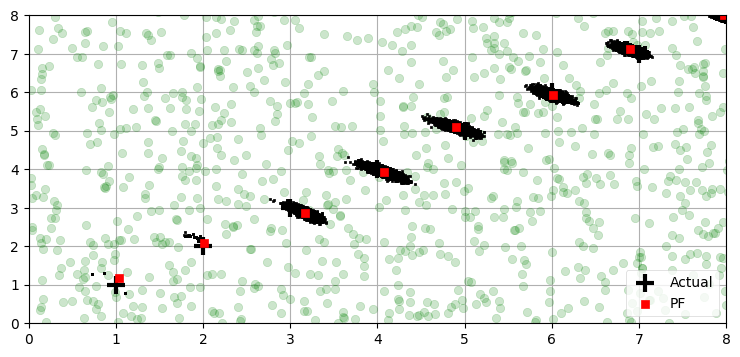

In [18]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

从图中看起来，前两个机器人位置只有几个粒子。这不是真的;有 5,000 个粒子，但由于重采样，大多数粒子彼此重复。原因是传感器的高斯分布非常窄。这称为*样本贫困*，可能导致过滤器发散。我将在下面详细讨论这个问题。现在，在 x=2 处查看第二步，我们可以看到粒子已经分散了一点。这种分散是由于运动模型噪声造成的。所有粒子都根据控制输入“u”向前投射，但噪声被添加到每个粒子，与机器人控制机制中的误差成正比。到第三步，粒子已经分散到足以在机器人周围形成令人信服的粒子云。

粒子云的形状是椭圆。这并非巧合。传感器和机器人控制都建模为高斯分布，因此系统的概率分布也是高斯分布。粒子滤波器是对概率分布的采样，所以云应该是一个椭圆。

重要的是要认识到粒子滤波器算法*不要求*传感器或系统是高斯或线性的。因为我们用粒子云表示概率分布，所以我们可以处理任何概率分布和强非线性问题。概率模型中可能存在不连续性和硬限制。

### Effect of Sensor Errors on the Filter

过滤器的前几次迭代产生了许多重复的粒子。发生这种情况是因为传感器的模型是高斯模型，我们给它一个小的标准偏差 $\sigma=0.1$。这起初是违反直觉的。当噪声较小时，卡尔曼滤波器的性能更好，但粒子滤波器的性能可能更差。


我们可以推理为什么这是真的。如果 $\sigma=0.1$，则机器人在 (1, 1) 处，粒子在 (2, 2) 处，粒子距离机器人 14 个标准差。这使它的概率接近于零。它对均值的估计没有任何贡献，并且在重采样后极不可能存活。如果 $\sigma=1.4$ 则粒子距离 $1\sigma$ 仅 $1\sigma$，因此它将有助于均值的估计。在重采样期间，它很可能被复制一次或多次。

理解这一点*非常重要* - 非常准确的传感器可能会导致过滤器性能不佳，因为很少有粒子会成为概率分布的良好样本。我们有一些可用的修复程序。首先，我们可以人为地增加传感器噪声标准偏差，这样粒子滤波器将接受更多点作为匹配机器人概率分布。这不是最佳的，因为其中一些点将是糟糕的匹配。真正的问题是没有足够的点生成，以至于足够多的点靠近机器人。增加`N` 通常可以解决这个问题。这个决定不是免费的，因为增加粒子数量会显着增加计算时间。不过，让我们看看使用 100,000 个粒子的结果。

final position error, variance:
	 [-0.17   0.084] [0.005 0.005]


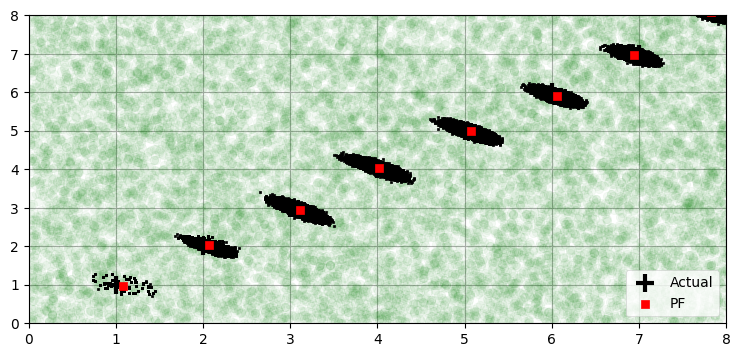

In [19]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

在 x=1 处有更多的粒子，我们在 x=2 处有一个令人信服的云。 显然，过滤器的性能更好，但代价是内存使用量大和运行时间长。

另一种方法是更智能地生成初始粒子云。 假设我们猜测机器人在 (0, 0) 附近。 这并不准确，因为模拟实际上将机器人放置在 (1, 1) 处，但很接近。 如果我们在 (0, 0) 附近创建一个正态分布的云，那么粒子匹配机器人位置的机会就会大得多。

`run_pf1()` 有一个可选参数 `initial_x`。 使用它来指定机器人的初始位置猜测。 然后代码使用`create_gaussian_particles(mean, std, N)`来创建围绕初始猜测正态分布的粒子。 我们将在下一节中使用它。

### Filter Degeneracy From Inadequate Samples

所写的过滤器远非完美。 这是它如何使用不同的随机种子执行。

final position error, variance:
	 [ -2.688 -31.47 ] [47.065 47.03 ]


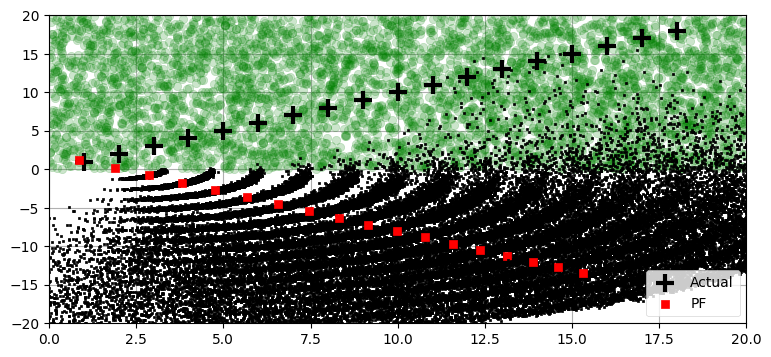

In [20]:
seed(6) 
run_pf1(N=5000, plot_particles=True, ylim=(-20, 20))

这里的初始点样本没有在机器人附近生成任何点。 粒子滤波器在重采样操作期间不会创建新点，因此它最终会复制不是概率分布的代表性样本的点。 如前所述，这称为*样本贫困*。 问题很快就失控了。 粒子与景观测量不匹配，因此它们以高度非线性的弯曲分布分散，并且粒子过滤器偏离现实。 机器人附近没有可用的粒子，因此它永远不会收敛。

让我们使用 `create_gaussian_particles()` 方法来尝试在机器人附近生成更多点。 我们可以通过使用 `initial_x` 参数来指定创建粒子的位置。

final position error, variance:
	 [ 0.035 -0.077] [0.007 0.009]


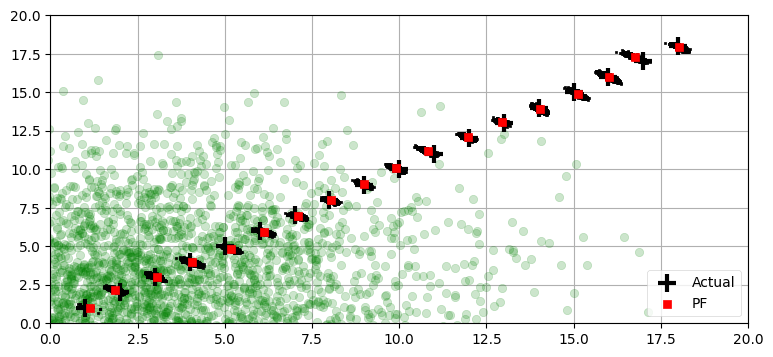

In [21]:
seed(6) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

这很好用。 如果您有任何粗略估计它的方法，您应该始终尝试在初始位置附近创建粒子。 不要*太* - 如果您在非常靠近单个位置的位置生成所有点，则粒子可能不会分散到足以捕获系统中的非线性。 这是一个相当线性的系统，因此我们可以在分布中使用较小的方差。 显然，这取决于您的问题。 增加颗粒数量总是获得更好样品的好方法，但处理成本可能比您愿意支付的价格更高。

## Importance Sampling


我已经挥手摆脱了我们现在必须面对的困难。有一些概率分布描述了我们机器人的位置和运动。我们想从该分布中抽取粒子样本并使用 MC 方法计算积分。

我们的困难是在许多问题中我们不知道分布。例如，被跟踪对象的移动可能与我们使用状态模型预测的非常不同。我们如何从未知的概率分布中抽取样本？

统计学中有一个定理，称为 [*重要性抽样*](https://en.wikipedia.org/wiki/Importance_sampling)[1]。值得注意的是，它为我们提供了一种从不同的已知概率分布中抽取样本的方法，并使用它们来计算未知概率分布的属性。这是一个奇妙的定理，给我的心带来欢乐。

这个想法很简单，我们已经使用了它。我们从已知的概率分布中抽取样本，但根据我们感兴趣的分布对样本进行加权。然后我们可以通过计算样本的加权均值和加权方差来计算均值和方差等属性。

对于机器人定位问题，我们从状态模型预测步骤计算出的概率分布中抽取样本。换句话说，我们推断“机器人在那里，它可能正在以这个方向和速度移动，因此它可能在这里”。然而，机器人可能做了一些完全不同的事情。它可能从悬崖上掉下来或被迫击炮弹击中。在每种情况下，概率分布都不正确。看起来我们受阻了，但并不是因为我们可以使用重要性采样。我们从可能不正确的概率分布中提取粒子，然后根据粒子与测量结果的匹配程度对它们进行加权。该权重基于真实概率分布，因此根据理论，所得均值、方差等将是正确的！

这怎么可能是真的？我会给你算术；如果您不打算超越机器人定位问题，则可以安全地跳过此步骤。然而，其他粒子过滤器问题需要不同的重要性采样方法，一些数学知识会有所帮助。此外，网络上的文献和大部分内容都使用数学公式来支持我相当不精确的“想象……”阐述。如果您想了解文献，您将需要知道以下等式。

我们有一些我们想从中取样的概率分布 $\pi(x)$。然而，我们不知道 $\pi(x)$ 是什么；相反，我们只知道另一种概率分布 $q(x)$。在机器人定位的上下文中，$\pi(x)$ 是机器人的概率分布，但我们不知道，而 $q(x)$ 是我们知道的测量值的概率分布。

具有概率分布 $\pi(x)$ 的函数 $f(x)$ 的期望值为


$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\, dx$$

我们不知道 $\pi(x)$ 所以我们无法计算这个积分。 我们确实知道另一种分布 $q(x)$，因此我们可以将其添加到积分中而无需更改值

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\frac{q(x)}{q(x)}\, dx$$

现在我们重新排列和分组术语

$$\mathbb{E}\big[f(x)\big] = \int f(x)q(x)\, \,  \cdot \,  \frac{\pi(x)}{q(x)}\, dx$$

$q(x)$ 是我们已知的，因此我们可以使用 MC 积分计算 $\int f(x)q(x)$。 这给我们留下了 $\pi(x)/q(x)$。 这是一个比率，我们将其定义为*权重*。 这给了我们


$$\mathbb{E}\big[f(x)\big] = \sum\limits_{i=1}^N f(x^i)w(x^i)$$

也许这看起来有点抽象。 如果我们想计算粒子的平均值，我们将计算

$$\mu = \frac{1}{N}\sum\limits_{i=1}^N x^iw^i$$

这是我在本章前面给你的等式。

要求权重与比率 $\pi(x)/q(x)$ 成正比。 我们通常不知道确切的值，因此在实践中我们通过将权重除以 $\sum w(x^i)$ 来标准化权重。

当您制定粒子滤波器算法时，您必须根据您的具体情况来实施此步骤。 对于机器人定位，用于 $q(x)$ 的最佳分布是来自过滤器 `predict()` 步骤的粒子分布。 我们再看一遍代码：

```python
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        dist = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(dist, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
```

这里我们根据贝叶斯计算 $\| 计算权重 \text{可能性} \times \text{prior}\|$

当然，如果您可以根据先验计算后验概率分布，则应该这样做。 如果你不能，那么重要性采样为你提供了一种解决这个问题的方法。 在实践中，计算后验是非常困难的。 卡尔曼滤波器取得了巨大的成功，因为它利用了高斯函数的特性来找到解析解。 一旦我们放宽了卡尔曼滤波器（马尔可夫特性、高斯测量和过程）所需的条件，重要性采样和蒙特卡罗方法就会使问题变得易于处理。

## Resampling Methods


重采样算法会影响滤波器的性能。例如，假设我们通过随机选取粒子来重新采样粒子。这将导致我们选择许多具有非常低权重的粒子，并且由此产生的粒子集将是问题概率分布的糟糕表现。

对该主题的研究仍在继续，但少数算法在实践中适用于各种情况。我们需要一种具有多种属性的算法。它应该优先选择具有更高概率的粒子。它应该选择具有较高概率粒子的代表性群体，以避免样本贫化。它应该包含足够多的低概率粒子，以使过滤器有机会检测到强非线性行为。

FilterPy 实现了几种流行的算法。 FilterPy 不知道您的粒子过滤器是如何实现的，因此它无法生成新样本。相反，算法会创建一个“numpy.array”，其中包含所选粒子的索引。您的代码需要执行重采样步骤。例如，我将其用于机器人：

In [22]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

### Multinomial Resampling

多项式重采样是我在开发机器人定位示例时使用的算法。 这个想法很简单。 计算归一化权重的累积总和。 这为您提供了一个从 0 到 1 递增值的数组。这是一个图表，说明了这是如何将权重隔开的。 颜色没有意义，它们只是使分区更容易看到。

cumulative sume is [0.1 0.3 0.4 1. ]


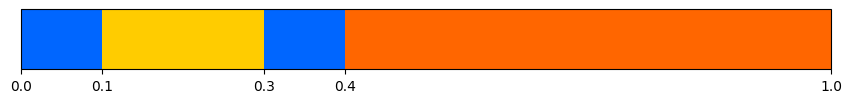

In [23]:
from kf_book.pf_internal import plot_cumsum
print('cumulative sume is', np.cumsum([.1, .2, .1, .6]))
plot_cumsum([.1, .2, .1, .6])

为了选择一个权重，我们生成一个在 0 和 1 之间均匀选择的随机数，并使用二分搜索找到它在累积和数组中的位置。 大权重比低权重占用更多空间，因此更有可能被选中。

这很容易使用 NumPy 的 [ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) 支持进行编码。 Ufuncs 将函数应用于数组的每个元素，返回结果数组。 `searchsorted` 是 NumPy 的二分搜索算法。 如果您为它提供一组搜索值，它将返回一组答案：每个搜索值都有一个答案。

In [24]:
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))    

下面是一个例子：

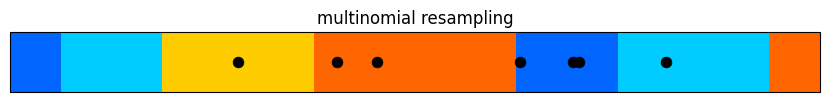

In [25]:
from kf_book.pf_internal import plot_multinomial_resample
plot_multinomial_resample([.1, .2, .3, .4, .2, .3, .1])

这是一个 $O(n \log(n))$ 算法。 这并不可怕，但是有 $O(n)$ 重采样算法在样本的均匀性方面具有更好的特性。 我展示它是因为您可以将其他算法理解为该算法的变体。 使用分布的 CDF 的倒数，可以更快地实现这种多项式重采样。 如果你有兴趣，你可以在互联网上搜索。

使用从 FilterPy 导入函数

```python
from filterpy.monte_carlo import multinomal_resample
```


### Residual Resampling

残差重采样既提高了多项式重采样的运行时间，又确保采样在整个粒子群中是均匀的。这是相当巧妙的：归一化的权重乘以 *N*，然后每个权重的整数值用于定义该粒子的样本数量。例如，如果粒子的权重为 0.0012 且 $N$=3000，则缩放权重为 3.6，因此将从该粒子中获取 3 个样本。这确保所有较高权重的粒子至少被选择一次。运行时间为 $O(N)$，使其比多项式重采样更快。

但是，这不会生成所有 *N* 选择。为了选择其余部分，我们取*残差*：权重减去整数部分，剩下数字的小数部分。然后我们使用更简单的采样方案，例如多项式，根据残差选择其余的粒子。在上面的示例中，缩放权重为 3.6，因此残差将为 0.6 (3.6 - int(3.6))。该残差非常大，因此很可能再次对粒子进行采样。这是合理的，因为残差越大，舍入误差越大，因此粒子在整数步中采样相对不足。

In [26]:
def residual_resample(weights):
    N = len(weights)
    indexes = np.zeros(N, 'i')

    # take int(N*w) copies of each weight
    num_copies = (N*np.asarray(weights)).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormial resample on the residual to fill up the rest.
    residual = w - num_copies     # get fractional part
    residual /= sum(residual)     # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes

您可能想用切片索引 [k:k + num_copies[i]] = i 替换内部 for 循环，但非常短的切片相对较慢，而且 for 循环通常运行得更快。

让我们看一个例子：

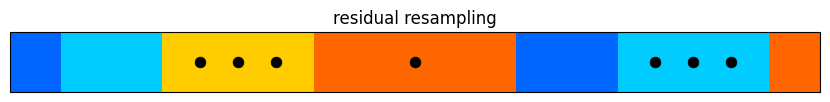

In [27]:
from kf_book.pf_internal import plot_residual_resample
plot_residual_resample([.1, .2, .3, .4, .2, .3, .1])

You may import this from FilterPy using

```python
    from filterpy.monte_carlo import residual_resample
```

### Stratified Resampling

该方案旨在在粒子上相对均匀地进行选择。 它的工作原理是将累积和分成 $N$ 个相等的部分，然后从每个部分中随机选择一个粒子。 这保证了每个样本的间隔在 0 和 $\frac{2}{N}$ 之间。

下图说明了这一点。 彩色条显示数组的累积总和，黑线显示 $N$ 等分。 粒子，显示为黑色圆圈，随机放置在每个细分中。

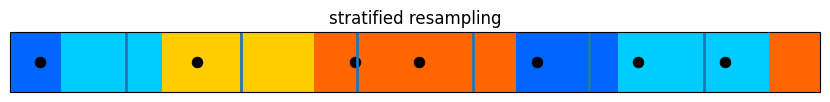

In [28]:
from kf_book.pf_internal import plot_stratified_resample
plot_stratified_resample([.1, .2, .3, .4, .2, .3, .1])

执行分层的代码非常简单。

In [29]:
def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

Import it from FilterPy with

```python
from filterpy.monte_carlo import stratified_resample
```



### Systematic Resampling

我们将研究的最后一个算法是系统重采样。 与分层重采样一样，空间被划分为 $N$ 个分区。 然后我们选择一个随机偏移量用于所有的划分，确保每个样本恰好是 $\frac{1}{N}$ 分开。 看起来像这样。

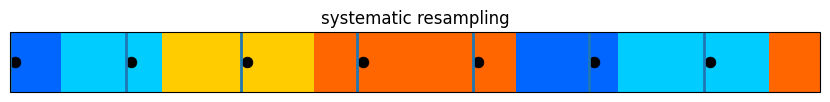

In [30]:
from kf_book.pf_internal import plot_systematic_resample
plot_systematic_resample([.1, .2, .3, .4, .2, .3, .1])

看过前面的例子，代码再简单不过了。

In [31]:
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions 
    # with a consistent random offset
    positions = (np.arange(N) + random()) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

Import from FilterPy with

```python
from filterpy.monte_carlo import systematic_resample
 ```

### Choosing a Resampling Algorithm

让我们同时看一下这四种算法，以便于比较它们。

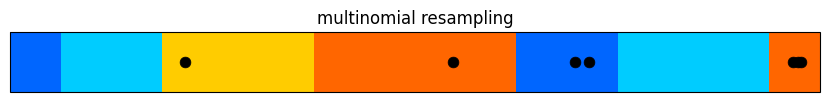

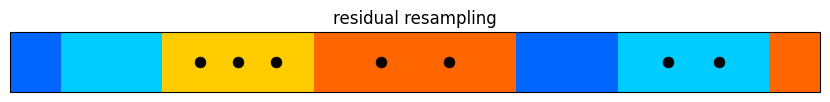

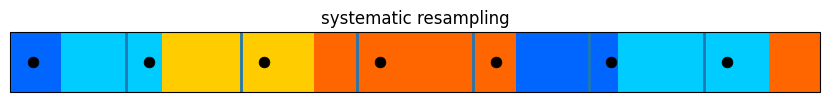

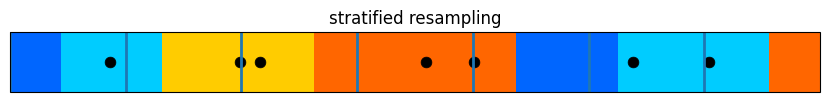

In [32]:
a = [.1, .2, .3, .4, .2, .3, .1]
np.random.seed(4)
plot_multinomial_resample(a)
plot_residual_resample(a)
plot_systematic_resample(a)
plot_stratified_resample(a)

多项式重采样的性能很差。有一个非常大的权重根本没有被采样。最大的权重只得到一次重采样，而最小的权重则被采样两次。我读过的网络上的大多数教程都使用多项式重采样，但我不知道为什么。多项式重采样在文献或实际问题中很少使用。我建议不要使用它，除非你有很好的理由这样做。

残差重采样算法在它试图做的事情上做得非常好：确保所有最大的权重都被多次重采样。它不会将样本均匀地分布在粒子上 - 许多相当大的权重根本不会被重新采样。

系统性和分层性都表现得非常好。系统采样做得很好，可以确保我们从粒子空间的所有部分采样，同时确保更大的权重被更频繁地按比例重新采样。分层重采样不像系统重采样那么统一，但它在确保更高的权重得到更多重采样方面要好一些。

关于这些算法的理论性能已经写了很多，请随意阅读。在实践中，我将粒子过滤器应用于抵抗分析工作的问题，因此我有点怀疑对这些问题进行特定分析的有效性。在实践中，分层算法和系统算法在各种问题上都表现良好且相似。我说试一试，如果有效就坚持下去。如果过滤器的性能很关键，请尝试两者，也许看看是否有关于您的特定问题的文献可以为您提供更好的指导。

## Summary

本章只触及了一个庞大主题的表面。我的目标不是教你这个领域，而是让你接触实用的贝叶斯蒙特卡罗过滤技术。

粒子过滤器是一种*整体*过滤。卡尔曼滤波器用高斯表示状态。使用贝叶斯定理将测量应用于高斯，并使用状态空间方法完成预测。这些技术应用于高斯-概率分布。

相比之下，集成技术使用离散的点集合和相关概率来表示概率分布。测量值应用于这些点，而不是高斯分布。同样，系统模型应用于点，而不是高斯模型。然后我们计算所得点集合的统计特性。

这些选择有很多权衡。卡尔曼滤波器非常有效，如果线性和高斯噪声的假设为真，则它是最佳估计器。如果问题是非线性的，那么我们必须将问题线性化。如果问题是多模态的（被跟踪的对象不止一个），那么卡尔曼滤波器就无法表示它。卡尔曼滤波器要求您了解状态模型。如果您不知道系统的行为方式，则性能会很差。

相比之下，粒子滤波器适用于任何任意的非解析概率分布。粒子的集合，如果足够大，就会形成分布的精确近似值。即使在存在严重非线性的情况下，它也能表现出色。即使我们不知道潜在的概率分布，重要性抽样也允许我们计算概率。 Monte Carlo 技术取代了其他滤波器所需的解析积分。

这种力量是有代价的。最明显的成本是过滤器给计算机带来的高计算和内存负担。不太明显的是，他们是善变的。您必须小心避免粒子简并和发散。证明过滤器的正确性可能非常困难。如果您正在使用多模态分布，则需要进一步工作来聚类粒子以确定多个对象的路径。当对象彼此靠近时，这可能非常困难。

有许多不同类别的粒子过滤器；我只描述了简单的 SIS 算法，然后介绍了一个性能良好的 SIR 算法。过滤器有很多类，每个类中有许多过滤器示例。描述它们需要一本小书。

当您阅读有关粒子滤波器的文献时，您会发现它散布着积分。我们使用积分对概率分布进行计算，因此使用积分为作者提供了强大而紧凑的符号。您必须认识到，当您将这些方程简化为代码时，您将用粒子表示分布，并且积分将替换为粒子上的总和。如果您牢记本章中的核心思想，那么材料应该不会令人生畏。

## References

[1] *Importance Sampling*, Wikipedia.
https://en.wikipedia.org/wiki/Importance_sampling